In [1]:
import data
import losses

In [2]:
import zipfile
import time

import torch
from torch import nn
from torch.utils.data import Dataset
import torchaudio
import torchaudio.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import scipy

These are the model requirements:

- Input to network can be 241 mel-bands otherwise you need to change the pre-processor / post-processor yourself (that is also an option)
- The input audio file will be resampled to fs=16000Hz
- Needs to be uploadable to jupyter so model size needs to be less than 1Gb
- There are two expected outputs: estimated_spec, gains

In [3]:
# From Exercise 5 code

class PreProcessing(torch.nn.Module):
    def __init__(
        self,
        input_samplerate    = 16000,
        resample_samplerate = 16000,
        window_length_ms    = 30
    ):
        super().__init__()
        self.resample = torchaudio.transforms.Resample(orig_freq=input_samplerate, new_freq=resample_samplerate)
        n_fft = (2*window_length_ms * resample_samplerate) // 2000
        hop_length = n_fft // 2
        self.spec = torchaudio.transforms.Spectrogram(n_fft=n_fft,power=None,hop_length=hop_length)
        self.output_size = (n_fft+2)//2
        

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        
        # Resample the input
        # Convert to power spectrogram
        resampled = self.resample(waveform)
        spec = self.spec(resampled).mT
        
        return spec

        

class PostProcessing(torch.nn.Module):
    def __init__(
        self,
        output_samplerate   = 16000,
        resample_samplerate = 16000,
        window_length_ms    = 30
    ):
        super().__init__()
        self.resample = torchaudio.transforms.Resample(orig_freq=resample_samplerate, new_freq=output_samplerate)
        n_fft = (2*window_length_ms * resample_samplerate) // 2000
        hop_length = n_fft // 2
        self.invspec = torchaudio.transforms.InverseSpectrogram(n_fft=n_fft,hop_length=hop_length)
       
    def forward(self, spec: torch.Tensor) -> torch.Tensor:
        # Convert to power spectrogram
        # Resample the output
        waveform = self.invspec(spec.mT)
        resampled = self.resample(waveform)
        
        return resampled

In [4]:
class ExtractGRUOutput(torch.nn.Module):
    def __init__(self):
        super(ExtractGRUOutput, self).__init__()
    def forward(self, x):
        # x is a tuple (output, hidden)
        output, _ = x
        return output

In [9]:
class VADNoiseModelEnhancer(torch.nn.Module):
    def __init__(
        self,
        spec_size        = 241,
        input_samplerate = 16000,
        enhancer_size    = 128,
        noise_model_size = 64,
        vad_model_size   = 128,
        n_mels           = 24,
        smoothing        = 0.8,
        device='cpu'
    ):
        super().__init__()
        self.spec_size = spec_size
        self.n_mels = n_mels
        self.eval_state   = False
        self.smoothing    = smoothing        
        self.melscale_transform = torchaudio.functional.melscale_fbanks(
            self.spec_size,
            f_min       = 0,
            f_max       = input_samplerate / 2.0,
            n_mels      = n_mels,
            sample_rate = input_samplerate,
            norm        = 'slaney',
        )
        self.melscale_transform = self.melscale_transform.to(device)
        
        self.vad_model = torch.nn.Sequential(
            torch.nn.GRU(input_size=n_mels, hidden_size=vad_model_size, num_layers=1, batch_first=True),
            ExtractGRUOutput(),
            torch.nn.Linear(128, 1)
        )
        # Input to noise_model is concatenation of (VAD output, Spectrogram)
        self.noise_model = torch.nn.GRU(input_size=n_mels+1, hidden_size=noise_model_size, num_layers=1, batch_first=True)
        # Input to enchancer is concatenation of (Spectrogram, Noise estimation, VAD output)
        self.enh_model = torch.nn.Sequential(
            torch.nn.GRU(input_size=n_mels+noise_model_size+1, hidden_size=enhancer_size, num_layers=1, batch_first=True, bidirectional=True),
            ExtractGRUOutput(),
            torch.nn.Linear(enhancer_size*2, spec_size),
            torch.nn.Sigmoid()
        )
        
    def eval(self):
        self.eval_state = True
        return
    def train(self):
        self.eval_state = False
        return


    def forward(self, input_spec: torch.Tensor) -> torch.Tensor:
        # Melscale tensor is (n_frames,24) so for the matmul to work input_spec 
        # must be (10, 153, n_frames)
        input_features = torch.matmul(
            input_spec.abs()**2,
            self.melscale_transform)
        
        # Calculate the VAD output
        vad_output = self.vad_model(input_features)
        # Estimate the noise
        noise_in = torch.cat([input_features, vad_output], dim=-1)
        noise_estimation, _ = self.noise_model(noise_in)
        # Estimate the spectrogram
        gains = self.enh_model(torch.cat([input_features, noise_estimation, vad_output], dim=-1))
        # Final output is multiplication of input with gains.
        estimated_spec = input_spec * gains
        
        if self.eval_state:
            for k in range(gains.shape[-2]-1):
                gains[...,k+1,:] = (
                    (1-self.smoothing)*gains[...,k+1,:] +
                    self.smoothing    *gains[...,k,:] )

        return estimated_spec, gains

In [13]:
batch_size = 20
def train(dataloader, dataset, model, preprocessor, loss_fn, optimizer, scheduler, epochs=1):
    size = len(dataset)
    model.train()
    start_time = time.perf_counter()

    for epoch in range(epochs):
        for batch, (noisy_batch, clean_batch, sr) in enumerate(dataloader):
            # Preprocess the noisy_batch and clean target batch
            noisy_spec = preprocessor(noisy_batch)
            #print(f"noisy_spec shape: {noisy_spec.shape}")
            clean_spec = preprocessor(clean_batch)
            # Feed the preprocessed batch to the model
            noisy_out, gains = model(noisy_spec)
            #clean_out = model(clean_spec) # Why does the instruction say to feed "them" to enhancer? Why would we enhance the clean signal?
            #print(f"Model output {noisy_out.shape}, clean sample {clean_spec.shape}") # (batch_size, n_fft, n_frames)
            # Calculate the per-band gain
            #oracle_gains = calc_oracle_gains(noisy_spec, clean_spec)
            # Calculate the loss
            # MelLoss expects the input to be in the shape (batch_size, n_frames, n_fft)
            loss = loss_fn(noisy_out, clean_spec)
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
    
            #if (batch+1) % 10 == 0:
            if (batch+1) % batch_size == 0:
                curr_time = time.perf_counter()
                loss, current = loss.item(), 1 + (batch)*batch_size + epoch*size
                print(f"loss: {loss:>7f}  [{current:>5d}/{size*epochs:>5d}] at {curr_time-start_time:>5f} sec, lr {scheduler.get_last_lr()[0]:>6f}")
                start_time = curr_time

In [11]:
dataset = data.NoisySpeech(".")
preprocessor = PreProcessing(input_samplerate=48000)
postprocessor = PostProcessing()
print(f"Dataset size {len(dataset)} ie. {len(dataset)//batch_size} batches.")

Dataset size 11572 ie. 578 batches.


In [14]:
n_mels = 48
enhancer = VADNoiseModelEnhancer(n_mels = n_mels)
optimizer = torch.optim.Adam(enhancer.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda batch: (batch / 200) if batch < 200 else 1 - ((batch - 200) / 200) * (1 - 0.0001))
loss = losses.MelLoss(16000, n_stft=241, n_mels = n_mels)
total_size = len(dataset)
train_size = int(0.5 * total_size)
eval_size = int(0.10 * total_size)
remaining_size = total_size - train_size - eval_size
train_dataset, eval_dataset, _ = torch.utils.data.random_split(dataset, [train_size, eval_size, remaining_size])
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, collate_fn=data.collate_fn)
train(dataloader, dataset, enhancer, preprocessor, loss, optimizer, scheduler, epochs=1)

loss: 12.869268  [  381/11572] at 33.633488 sec, lr 0.000100
loss: 12.612225  [  781/11572] at 33.625716 sec, lr 0.000200
loss: 11.854537  [ 1181/11572] at 33.556209 sec, lr 0.000300
loss: 11.641463  [ 1581/11572] at 33.779526 sec, lr 0.000400
loss: 11.010595  [ 1981/11572] at 33.628904 sec, lr 0.000500
loss: 10.235388  [ 2381/11572] at 34.030509 sec, lr 0.000600
loss: 10.565525  [ 2781/11572] at 33.459244 sec, lr 0.000700
loss: 10.694283  [ 3181/11572] at 33.338929 sec, lr 0.000800
loss: 10.671033  [ 3581/11572] at 32.731775 sec, lr 0.000900
loss: 10.736073  [ 3981/11572] at 32.471765 sec, lr 0.001000
loss: 10.611105  [ 4381/11572] at 33.283677 sec, lr 0.000900
loss: 10.562010  [ 4781/11572] at 32.800241 sec, lr 0.000800
loss: 10.800611  [ 5181/11572] at 34.190191 sec, lr 0.000700
loss: 10.367003  [ 5581/11572] at 33.059293 sec, lr 0.000600


In [15]:
torch.save(enhancer.state_dict(), "baseline.pt") # 1.4M

In [16]:
eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=batch_size, shuffle=True, collate_fn=data.collate_fn)
total_mel_loss = 0
total_db_loss = 0
total_samples = 0
enhancer.eval()
db_loss = losses.dBLoss()

with torch.no_grad():
    for noisy_batch, clean_batch, sr in eval_dataloader:
        start_time = time.perf_counter()
        noisy_spec = preprocessor(noisy_batch)
        clean_spec = preprocessor(clean_batch)
        enhanced_spec,_ = enhancer(noisy_spec)
        loss_mel = loss(enhanced_spec, clean_spec)
        loss_db = db_loss(enhanced_spec, clean_spec)
        total_mel_loss += loss_mel.item() * noisy_batch.size(0)
        total_db_loss += loss_db.item() * noisy_batch.size(0)
        total_samples += noisy_batch.size(0)
        if total_samples % 100 == 0:
            curr_time = time.perf_counter()
            print(f"{total_samples} done. AVG MelLoss {(total_mel_loss / total_samples):>5f}, DBLoss {(total_db_loss / total_samples):>5f}")
            start_time = curr_time

avg_mel_loss = total_mel_loss / total_samples
avg_db_loss = total_db_loss / total_samples
print(f"Evaluation over {total_samples} samples. MelLoss {avg_mel_loss:>7f}. DBLoss {avg_db_loss:>7f}")
# Evaluation over 1157 samples. MelLoss 12.602210. DBLoss 13.163661

enhanced_batch = postprocessor(enhanced_spec)
clean_audio = postprocessor(clean_spec)
noisy_audio = postprocessor(noisy_spec)

100 done. AVG MelLoss 10.262533, DBLoss 11.368765
200 done. AVG MelLoss 10.296982, DBLoss 11.409528
300 done. AVG MelLoss 10.347703, DBLoss 11.454831
400 done. AVG MelLoss 10.319967, DBLoss 11.417501
500 done. AVG MelLoss 10.322031, DBLoss 11.416021
600 done. AVG MelLoss 10.292284, DBLoss 11.384588
700 done. AVG MelLoss 10.265406, DBLoss 11.367433
800 done. AVG MelLoss 10.266644, DBLoss 11.367648
900 done. AVG MelLoss 10.269134, DBLoss 11.374093
1000 done. AVG MelLoss 10.257720, DBLoss 11.363343
1100 done. AVG MelLoss 10.265650, DBLoss 11.370240
Evaluation over 1157 samples. MelLoss 10.268474. DBLoss 11.373375


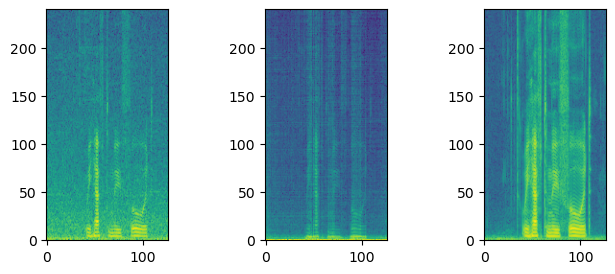

In [17]:
idx = np.random.randint(10)
plt.figure(figsize=(8,3))
plt.subplot(131)
plt.imshow(noisy_spec[idx,:,:].to('cpu').abs().log().mT.numpy(),origin='lower')
plt.subplot(132)
plt.imshow(enhanced_spec[idx,:,:].to('cpu').abs().log().mT.detach().numpy(),origin='lower')
plt.subplot(133)
plt.imshow(clean_spec[idx,:,:].to('cpu').abs().log().mT.numpy(),origin='lower')
plt.show()

import IPython
IPython.display.display(IPython.display.Audio(noisy_batch[idx,:].detach().numpy(),rate=int(sr)))
IPython.display.display(IPython.display.Audio(enhanced_batch[idx,:].detach().numpy(),rate=16000))
IPython.display.display(IPython.display.Audio(clean_batch[idx,:],rate=int(sr)))